# HW 7: Dimensionality reduction

The goal is to build machine learning models to estimate one's public speaking anxiety from bio-behavioral data. The data comes from the VerBio dataset, which was collected with the goal to better understand individuals' affective responses while performing public speaking tasks. More details about the dataset, including the experimental setup and type of data, can be found here: https://hubbs.engr.tamu.edu/resources/verbio-dataset/.

The data is uploaded on CANVAS and includes 55 participants. We have one presentation for each participant, which results in 55 data samples. The "data.csv" file that contains a set of bio-behavioral features (i.e., skin conductance level, skin conductance response amplitude, skin conductance response frequency, heart rate, wrist acceleration, interbeat interval, speech energy, 12 speech mel-frequency cepstral coefficients (MFCCs), speech zero crossing rate, speech voicing probability, speech fundamental frequency (F0), speech pause frequency), label (i.e., state anxiety), and participants' language information (i.e., native/non-native English speaker). Each row in the csv file corresponds to one data sample. The bio-behavioral features were computed based on the entire presentation for each participant.

## (a) Data pre-processing
Identify missing data values and replace them with the corresponding feature mean.

In [165]:
import csv 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [2]:
# read csv file 
data = []
data_path = "data.csv"

with open(data_path, 'r', encoding='utf-8-sig') as f:
    csv_file = csv.reader(f)
    data = [row for row in csv_file]

In [3]:
df = pd.DataFrame(data)
new_header = df.iloc[0] # grab the first row for the header
df = df[1:] # take the data less the header row
df.columns = new_header
df.head()

,PID,SCL,SCRamp,SCRfreq,HR,BVP,TEMP,ACC,IBI,RMSenergy,...,mfcc[9],mfcc[10],mfcc[11],mfcc[12],zcr,voiceProb,F0,pause_frequency,StateAnxiety,Language
1,P001,0.353694542,0.049017498,9.649805447,79.04321244,0.03971799,33.16005188,62.89235567,0.859414333,0.027971981,...,-2.724729485,-3.590817861,0.39038344,-11.85513391,0.071546573,0.516881484,95.47320932,3.857142857,62,2
2,P003,0.424881154,0.040277009,12.0754717,90.67472803,-0.012489676,33.560587,66.50715626,,0.025150245,...,-0.994850967,-5.456365037,-1.185722752,-4.423543868,0.088058334,0.493522682,77.45466101,0.888888889,41,1
3,P004,0.164890091,0.006638833,1.730769231,82.39349359,0.162948012,31.74230769,65.21567384,0.774073846,0.021411449,...,-7.322685216,-4.966898789,-8.985444317,-8.322640694,0.07327186,0.581679662,132.8558223,1,39,2
4,P005,0.85070951,0.040912997,13.97727273,87.31784091,-0.011401703,31.15701705,64.43825796,0.448681143,0.008874291,...,-8.647626987,1.977405603,-0.627533467,-1.1523338,0.052280549,0.51024507,96.28413316,2.428571429,40,2
5,P006,2.918752269,0.175392157,18.88594164,80.05480565,0.001135861,33.05362511,63.15713836,0.734409,0.01189714,...,6.593793786,3.238551575,7.198553223,1.251417088,0.027679581,0.437491946,34.32755922,1.818181818,50,2


In [4]:
# convert data types for the features 
features = df.columns[1:]
features = df[features].apply(pd.to_numeric, errors='coerce')
features.head()

,SCL,SCRamp,SCRfreq,HR,BVP,TEMP,ACC,IBI,RMSenergy,mfcc[1],...,mfcc[9],mfcc[10],mfcc[11],mfcc[12],zcr,voiceProb,F0,pause_frequency,StateAnxiety,Language
1,0.353695,0.049017,9.649805,79.043212,0.039718,33.160052,62.892356,0.859414,0.027972,1.812113,...,-2.724729,-3.590818,0.390383,-11.855134,0.071547,0.516881,95.473209,3.857143,62.0,2
2,0.424881,0.040277,12.075472,90.674728,-0.012490,33.560587,66.507156,NaN,0.025150,0.895732,...,-0.994851,-5.456365,-1.185723,-4.423544,0.088058,0.493523,77.454661,0.888889,41.0,1
3,0.164890,0.006639,1.730769,82.393494,0.162948,31.742308,65.215674,0.774074,0.021411,-0.813331,...,-7.322685,-4.966899,-8.985444,-8.322641,0.073272,0.581680,132.855822,1.000000,39.0,2
4,0.850710,0.040913,13.977273,87.317841,-0.011402,31.157017,64.438258,0.448681,0.008874,-0.676535,...,-8.647627,1.977406,-0.627533,-1.152334,0.052281,0.510245,96.284133,2.428571,40.0,2
5,2.918752,0.175392,18.885942,80.054806,0.001136,33.053625,63.157138,0.734409,0.011897,-0.329363,...,6.593794,3.238552,7.198553,1.251417,0.027680,0.437492,34.327559,1.818182,50.0,2


## (b) Data exploration 
Provide visualizations of some of the features with respect to the state anxiety label (e.g., overlaying histograms, scatter plots), and quantify associations between the features and the label (e.g., via correlation coefficient). Please discuss your findings.

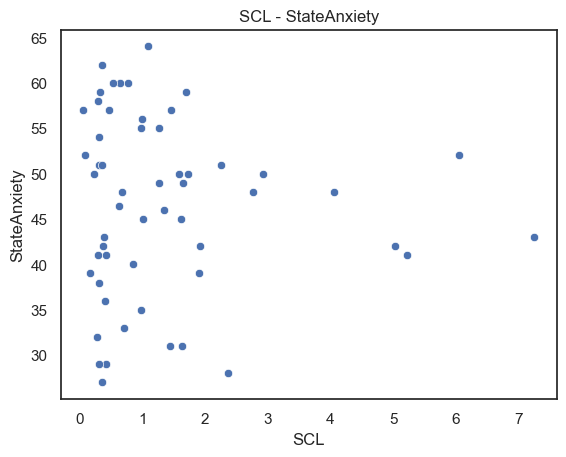

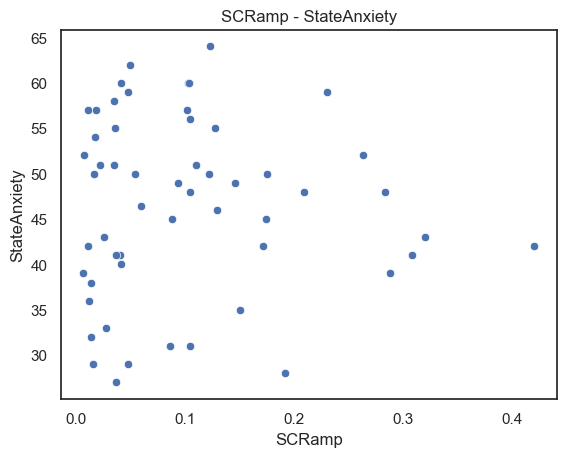

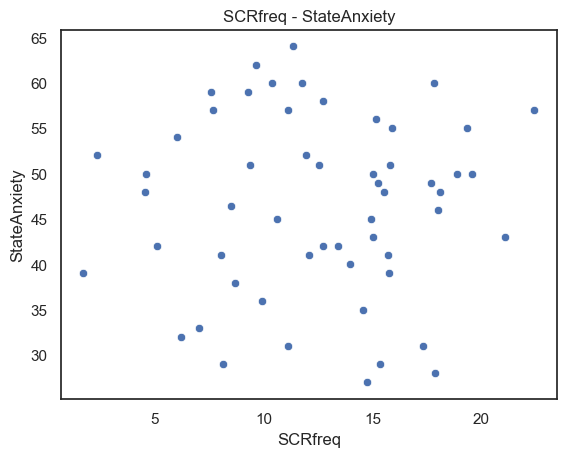

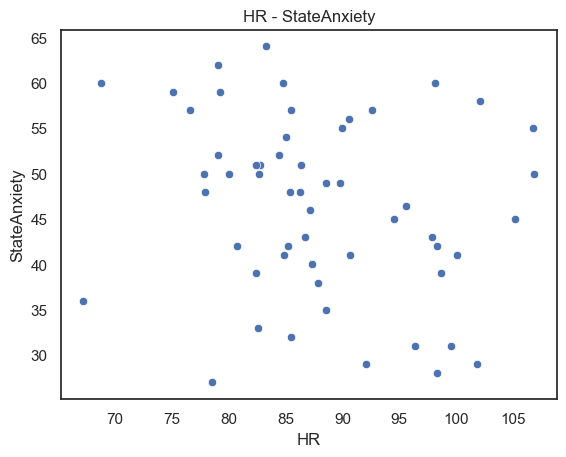

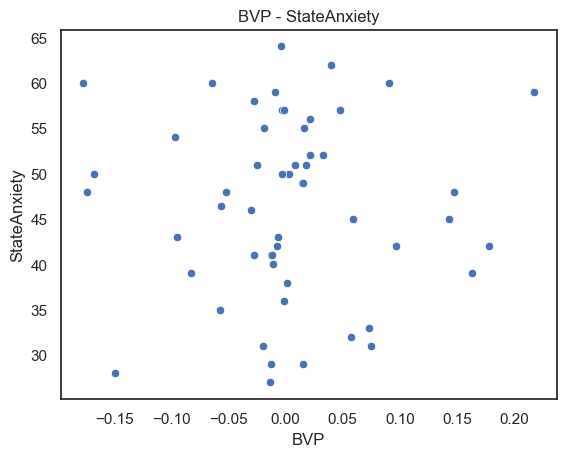

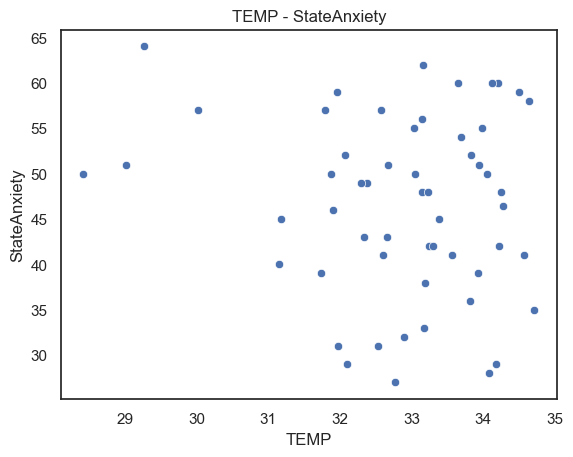

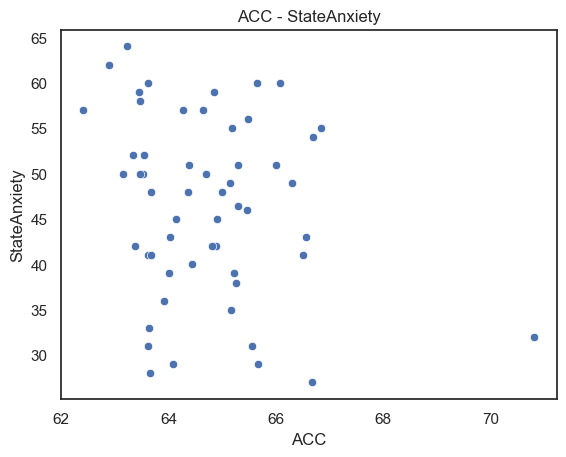

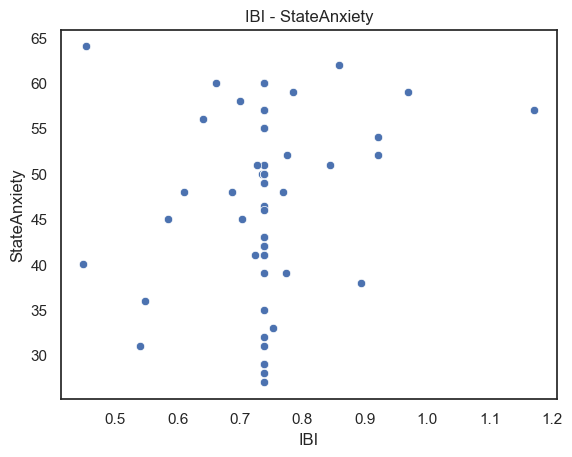

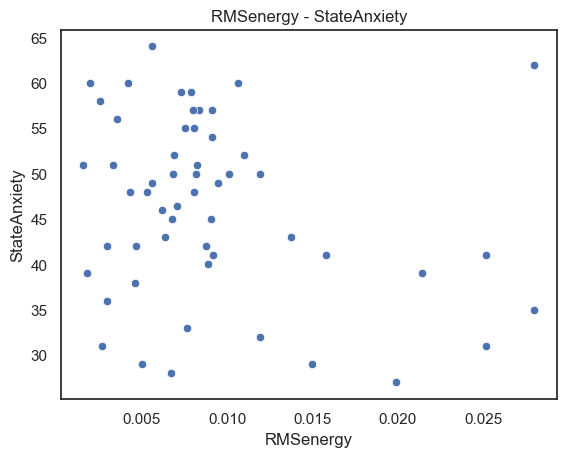

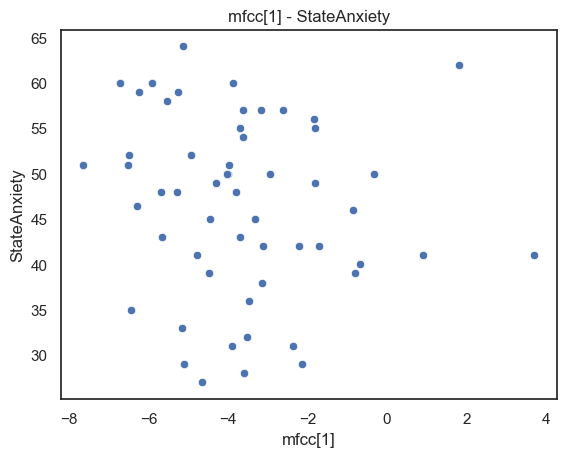

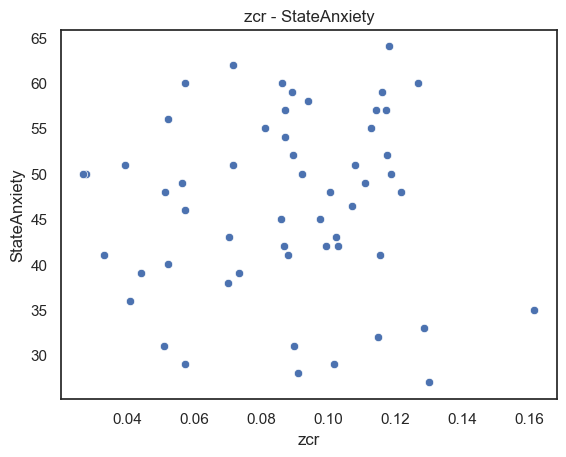

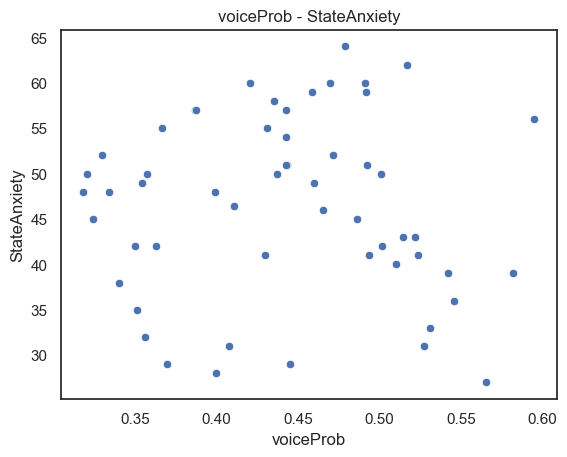

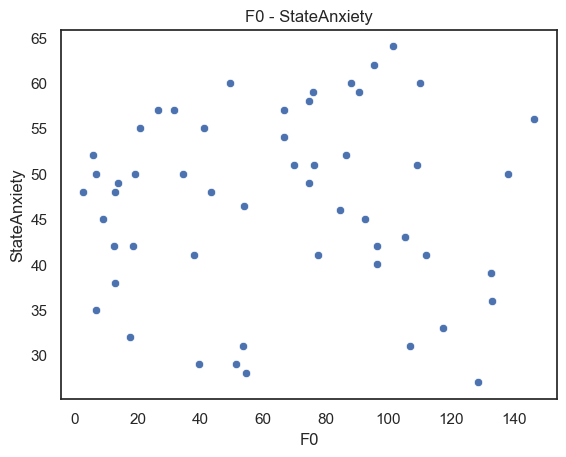

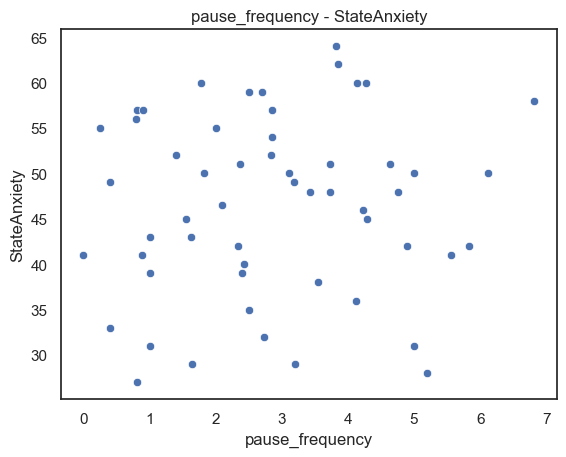

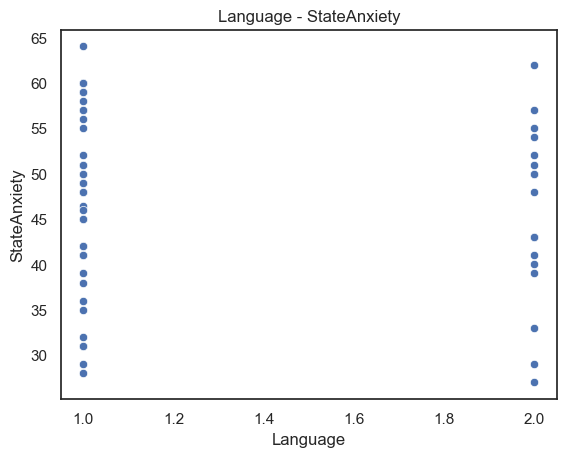

In [6]:
# plot the 2-D scatter plots
index_numerical = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 21, 22, 23, 24, 26]

sns.set_theme(style='white')
for i in index_numerical:
    sns.scatterplot(data= features, x=features[features.columns[i]], y=features['StateAnxiety'])
    plt.title(f"{features.columns[i]} - {'StateAnxiety'}")
    plt.show()

In [7]:
# compute the Pearson's correlation coefficients

list_corr_coef = []
index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26]

for i in index:
    list_corr_coef.append(np.corrcoef(features[features.columns[i]], features['StateAnxiety'])[0, 1])

for i, n in zip(index, range(26)):
    print(f"Pearson's correlation coefficient between {features.columns[i]} and {'StateAnxiety'}: {list_corr_coef[n]}")

Pearson's correlation coefficient between SCL and StateAnxiety: -0.049804667294520925
Pearson's correlation coefficient between SCRamp and StateAnxiety: -0.014173697358366292
Pearson's correlation coefficient between SCRfreq and StateAnxiety: 0.013869512677839924
Pearson's correlation coefficient between HR and StateAnxiety: -0.2170424118534046
Pearson's correlation coefficient between BVP and StateAnxiety: -0.00035485586179540083
Pearson's correlation coefficient between TEMP and StateAnxiety: -0.12054102158121277
Pearson's correlation coefficient between ACC and StateAnxiety: -0.216606272115361
Pearson's correlation coefficient between IBI and StateAnxiety: 0.18315643320166755
Pearson's correlation coefficient between RMSenergy and StateAnxiety: -0.23609034514486693
Pearson's correlation coefficient between mfcc[1] and StateAnxiety: -0.12590333392378003
Pearson's correlation coefficient between mfcc[2] and StateAnxiety: 0.08125579732950128
Pearson's correlation coefficient between mf

**IBI** (0.18) and **mfcc_10** (0.126) have the highest Pearson's correlation coefficient with StateAnxiety among the others. (**positive**)

**RMSenergy** (-0.236) and **HR** (-0.217) have the lowest Pearson's correlation coefficient with StateAnxiety among the others. (**negative**)

## (c) Data exploration
Provide visualizations of some of the features with respect to the participants' language information (e.g., bar plots for Native and Non-Native speakers), and identify whether these features depict differences between Native and Non-Native English
speakers (1: native, 2: non-native in "data.csv") (e.g., via Fisher's criterion). What might be potential sources of these differences (if any)?

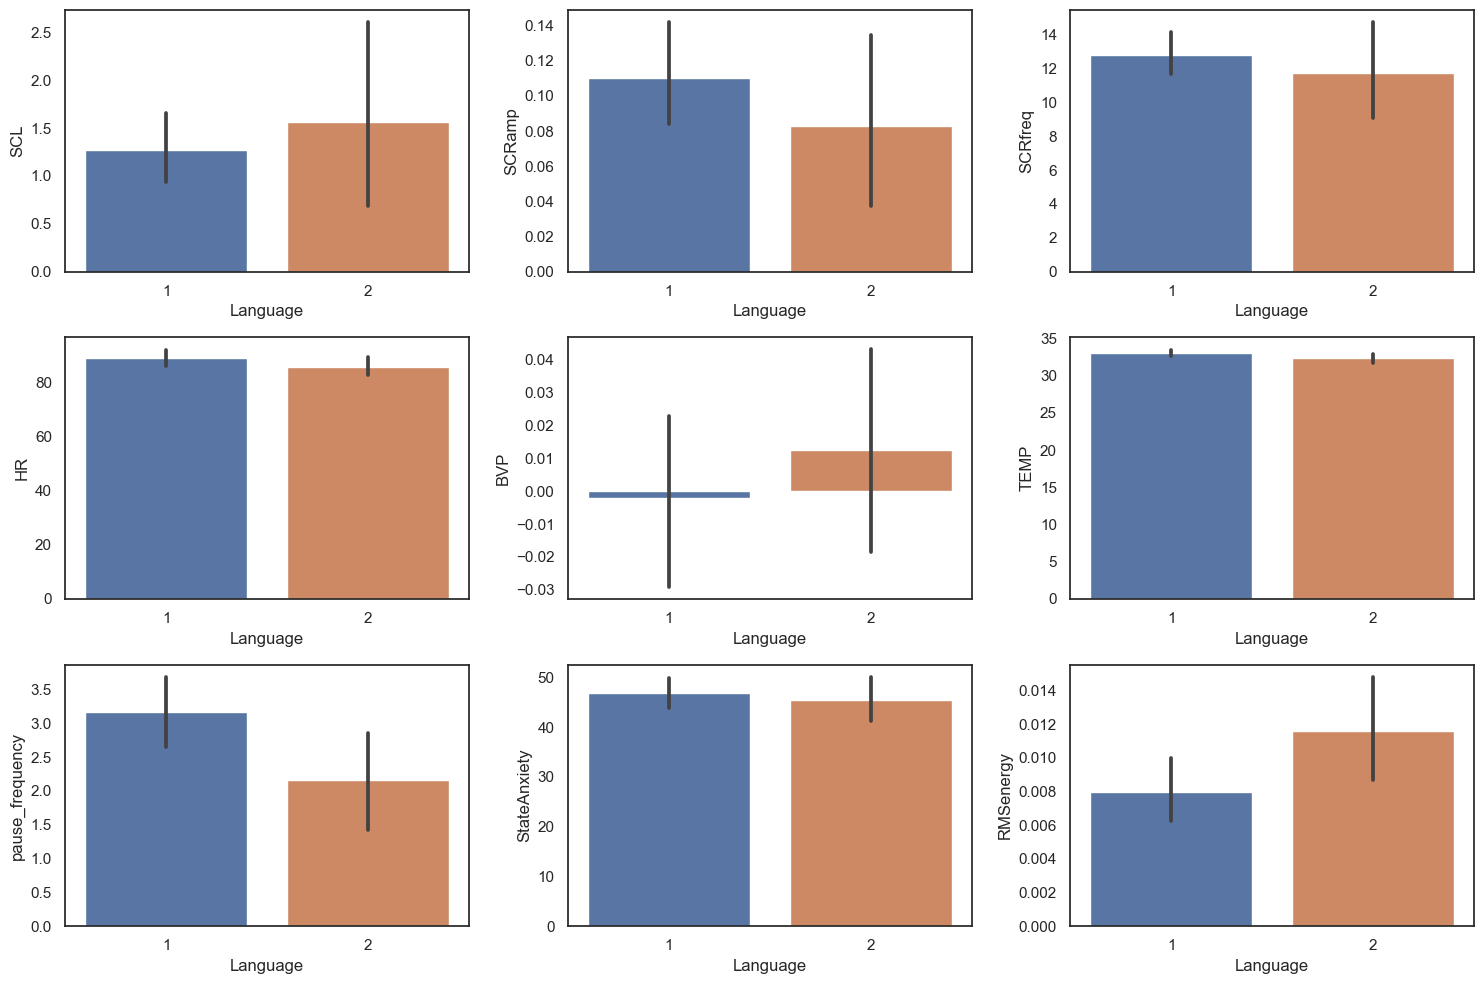

In [8]:
# create a figure with 9 subplots
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (15, 10))

sns.barplot(x = "Language", y = "SCL", data = features, ax = axes[0,0])
sns.barplot(x = "Language", y = "SCRamp", data = features, ax = axes[0,1])
sns.barplot(x = "Language", y = "SCRfreq", data = features, ax = axes[0,2])
sns.barplot(x = "Language", y = "HR", data = features, ax = axes[1,0])
sns.barplot(x = "Language", y = "BVP", data = features, ax = axes[1,1])
sns.barplot(x = "Language", y = "TEMP", data = features, ax = axes[1,2])
sns.barplot(x = "Language", y = "pause_frequency", data = features, ax = axes[2,0])
sns.barplot(x = "Language", y = "StateAnxiety", data = features, ax = axes[2,1])
sns.barplot(x = "Language", y = "RMSenergy", data = features, ax = axes[2,2])

# adjust the layout
plt.tight_layout()

# show the plot
plt.show()

**Conclusions**: The mean of SCL, BVP and RMSenergy are higher for non-Native speakers than Native speakers. The mean of SCRamp, SCRfreq and pause_frequency are higher for Native speakers than non-Native speakers. The potential sources of these differences might be attributed to the stimuli, such as emotional or physiological arousal being perceived by the speakers. It is anticipated that native speakers would be less nervous and more comfortable in presentation comparing to non-native speakers. However, the mean of skin conductance response amplitude (SCRamp), skin conductance response frequency (SCRfreq) and speech pause frequency are higher for native speaker which is counterintuitive and suggests that languages might not be the most important thing for evaluating one's public speaking anxiety. Other factors such as personality or experiences might impact the results and can be further explored. 

## (d) Feature selection for state anxiety
Explore a filter feature selection method of your choice to identify the bio-behavioral features that are the most informative
of the state anxiety label. Using any machine learning algorithm that you would like, plot the absolute error between the actual and predicted state anxiety values using a 5-fold cross-validation (i.e., average over the 5 folds) against different number of selected features. Please discuss the results.

In [ ]:
def rf_regression(X, y, num_features):
    # Initialize the random forest regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)

    # Initialize the KFold object for cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # Initialize the list to store the absolute errors for each fold
    abs_errors = []

    # Perform cross-validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index, :].iloc[:, :num_features], X.iloc[test_index, :].iloc[:, :num_features]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit the random forest regressor on the training data
        rf.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = rf.predict(X_test)

        # Calculate the absolute error between the actual and predicted values
        abs_error = mean_absolute_error(y_test, y_pred)

        # Add the absolute error to the list
        abs_errors.append(abs_error)

    # Calculate the average absolute error across the folds
    avg_abs_error = sum(abs_errors) / n_folds

    return avg_abs_error

Use Correlation as the filter feature selection method

Model 1: IBI & mfcc_10 as input features

In [53]:
X = features.iloc[:, [7,18]] # IBI & mfcc_10 as input features 
y = features[["StateAnxiety"]]

# Define the number of folds for cross-validation
n_folds = 5 

# Initialize the list to store the absolute errors for each model 
abs_errors = []

In [54]:
abs_errors.append(rf_regression(X,y,2))
abs_errors

C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fi

[7.640619528619529]

Model 2: IBI & mfcc_10 & mfcc_4 as input features

In [55]:
X = features.iloc[:, [7,12,18]] # IBI & mfcc_10 & mfcc_4 as input features 
y = features[["StateAnxiety"]]

In [56]:
abs_errors.append(rf_regression(X,y,2))
abs_errors

C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fi

[7.640619528619529, 8.426383838383838]

Model 3: RMSenergy & HR as input features 

In [57]:
X = features.iloc[:, [3,8]] # HR & RMSenergy as input features 
y = features[["StateAnxiety"]]

In [58]:
abs_errors.append(rf_regression(X,y,2))
abs_errors

C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fi

[7.640619528619529, 8.426383838383838, 8.387892255892258]

Model 4: IBI & mfcc_10 & RMSenergy & HR as input features

In [59]:
X = features.iloc[:, [3,7,8,18]] # HR & RMSenergy & IBI & mfcc_10 as input features 
y = features[["StateAnxiety"]]

In [60]:
abs_errors.append(rf_regression(X,y,4))
abs_errors

C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fi

[7.640619528619529, 8.426383838383838, 8.387892255892258, 7.649562289562292]

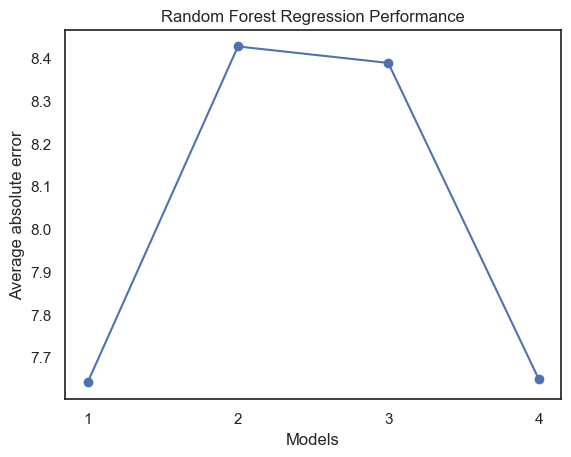

In [67]:
# Plot the results using a line graph

models = ['1','2','3','4']

plt.plot(models, abs_errors, 'bo-')
plt.xlabel('Models')
plt.ylabel('Average absolute error')
plt.title('Random Forest Regression Performance')
plt.show()

**Conclusion**: **Model 1** with 2 variables having the highest Pearson's correlation coefficient with StateAnxiety has the **lowest average absolute error**. **Model 2** combining the variables of Model 1 plus a variable with third highest correlation coefficient has the **highest average absolute error**. The error of Model 3 with 2 variables having the lowest Pearson's correlation coefficient with StateAnxiety dropped a bit comparing to Model 2, but was the second highest. Model 4 with 4 variables having 2 highest and 2 lowest correlation coefficient respectively performed almost the same with Model 1. Therefore, from the results we can conclude that model 1 including 2 variables with the highest Pearson's correlation coefficient predicts the state anxiety label most accurately.

Use different number of selected features in the model.

In [106]:
indexes = range(0,25)
mean_error = []

for i in indexes: 
    X = features.iloc[:, :i+1]
    y = features[["StateAnxiety"]]
    
    mean_error.append(rf_regression(X, y, i+1))
mean_error

C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fi

C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fi

C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fi

C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3807870786.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fi

[10.339589225589226,
 9.642060606060605,
 9.742404040404042,
 8.971696969696971,
 8.298632996632998,
 8.489158249158248,
 8.167151515151517,
 8.017063973063973,
 7.800350168350168,
 7.855010101010102,
 7.782653198653199,
 8.013542087542088,
 7.846255892255894,
 7.9834006734006735,
 7.622686868686867,
 7.968404040404041,
 7.893084175084175,
 7.911239057239058,
 7.536781144781145,
 7.8677777777777775,
 7.7831515151515145,
 7.780127946127948,
 7.476289562289563,
 7.55270707070707,
 7.531797979797981]

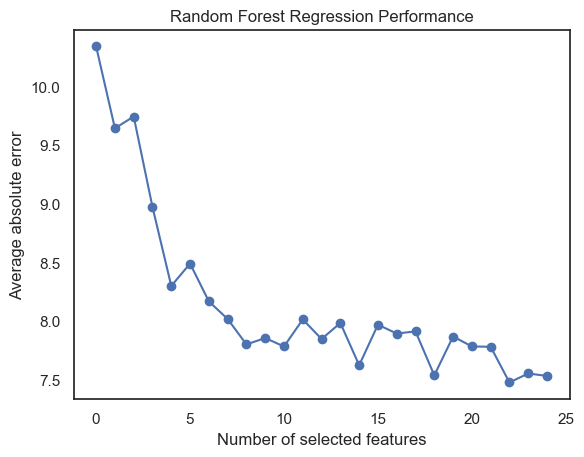

In [112]:
# Plot the results using a line graph

num_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19,20, 21, 22, 23, 24]

plt.plot(num_features, mean_error, 'bo-')
plt.xlabel('Number of selected features')
plt.ylabel('Average absolute error')
plt.title('Random Forest Regression Performance')
plt.show()

**Conclusion**: From the graph, we can see that the performance of the random forest regression improves as the number of selected features increases up to around 8, and then starts to level off.

## (e) Feature selection for Native English speaker classification
Explore a filter feature selection method of your choice to identify the bio-behavioral features that are the most informative of whether a speaker is a Native English speaker or not (1: native, 2: non-native in data.csv"). Using any machine learning algorithm that you would like, plot the binary classification accuracy between Native and Non-Native English speakers using a 5-fold cross-validation (i.e., average over the 5 folds) against different number of selected features. Please discuss the results.

Use Correlation as the filter feature selection method

In [74]:
# compute the Pearson's correlation coefficients

list_corr_coef = []
index = range(0,26)

for i in index:
    list_corr_coef.append(np.corrcoef(features[features.columns[i]], features['Language'])[0, 1])

for i in index:
    print(f"Pearson's correlation coefficient between {features.columns[i]} and {'Language'}: {list_corr_coef[i]}")

Pearson's correlation coefficient between SCL and Language: 0.09008433712012787
Pearson's correlation coefficient between SCRamp and Language: -0.13345922242883587
Pearson's correlation coefficient between SCRfreq and Language: -0.10271543690922964
Pearson's correlation coefficient between HR and Language: -0.17947740800825385
Pearson's correlation coefficient between BVP and Language: 0.08679254286602066
Pearson's correlation coefficient between TEMP and Language: -0.2433421871266833
Pearson's correlation coefficient between ACC and Language: -0.048482295624639356
Pearson's correlation coefficient between IBI and Language: 0.09353252697652781
Pearson's correlation coefficient between RMSenergy and Language: 0.26436213831988736
Pearson's correlation coefficient between mfcc[1] and Language: 0.2785420187640315
Pearson's correlation coefficient between mfcc[2] and Language: -0.07632751027810555
Pearson's correlation coefficient between mfcc[3] and Language: 0.13917794578134096
Pearson's 

**mfcc_1** (0.28) and **RMSenergy** (0.26) have the highest Pearson's correlation coefficient with Language among the others. (**positive**)

**pause_frequency** (-0.28) and **mfcc_12** (-0.27) have the lowest Pearson's correlation coefficient with Language among the others. (**negative**)

Model 1: mfcc_1 & RMSenergy as input features

In [135]:
# Load the dataset
X = features.iloc[:, [8,9]] # mfcc_1 and RMSenergy as input features 
y = features[["Language"]]


# Define an empty list to store the classification accuracy scores
acc_scores = []

In [136]:
# Create a random forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100, random_state=42)
    
# Use 5-fold cross-validation to evaluate the classification accuracy
kf = KFold(n_splits = 5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X, y, cv=kf)
    
# Calculate the average classification accuracy across the folds
acc_score = sum(scores) / len(scores)
acc_scores.append(acc_score) 

C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection

Model 2: mfcc_1 & RMSenergy & voiceProb as input features

In [138]:
# Load the dataset
X = features.iloc[:, [8,9,22]] # mfcc_1 and RMSenergy & voiceProb as input features 
y = features[["Language"]] 

In [139]:
# Create a random forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100, random_state=42)
    
# Use 5-fold cross-validation to evaluate the classification accuracy
kf = KFold(n_splits = 5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X, y, cv=kf)
    
# Calculate the average classification accuracy across the folds
acc_score = sum(scores) / len(scores)
acc_scores.append(acc_score) 

C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection

Model 3: pause_frequency & mfcc_12 as input features

In [141]:
# Load the dataset
X = features.iloc[:, [20,24]] # pause_frequency & mfcc_12 as input features 
y = features[["Language"]] 

In [142]:
# Create a random forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100, random_state=42)
    
# Use 5-fold cross-validation to evaluate the classification accuracy
kf = KFold(n_splits = 5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X, y, cv=kf)
    
# Calculate the average classification accuracy across the folds
acc_score = sum(scores) / len(scores)
acc_scores.append(acc_score) 

C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection

Model 4: mfcc_1 & RMSenergy & pause_frequency & mfcc_12 as input features

In [144]:
# Load the dataset
X = features.iloc[:, [8,9,20,24]] # mfcc_1 & RMSenergy & pause_frequency & mfcc_12 as input features 
y = features[["Language"]

In [145]:
# Create a random forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100, random_state=42)
    
# Use 5-fold cross-validation to evaluate the classification accuracy
kf = KFold(n_splits = 5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X, y, cv=kf)
    
# Calculate the average classification accuracy across the folds
acc_score = sum(scores) / len(scores)
acc_scores.append(acc_score) 

C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection

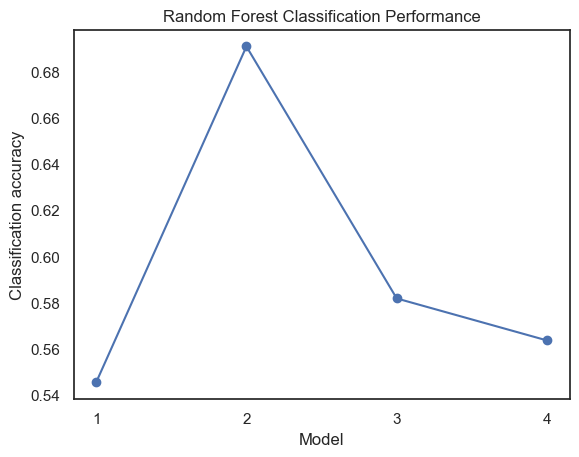

In [151]:
# Plot the classification accuracy against the number of selected features
plt.plot(models, acc_scores, 'bo-')
plt.xlabel('Model')
plt.ylabel('Classification accuracy')
plt.title('Random Forest Classification Performance')
plt.show()

**Conclusions**: Model 1 with 2 variables having the highest Pearson's correlation coefficient with Language has the **lowest classification accuracy**. Adding one variable which scores the third highest for the correlation coefficient to model 1 significantly increases the accuracy. Model 3 including 2 variables having the lowest Pearson's correlation coefficient did not perform as well as Model 2 but is slightly better than Model 1 and 4. Model 4 using the above 4 features did not perform very well whose accuracy is only slightly higher than Model 1. 

Use different number of selected features in the model.

In [152]:
indexes = range(0,26)
accuracy = []

for i in indexes: 
    X = features.iloc[:, :i+1]    
    y = features[["Language"]] 
    
    # Create a random forest classifier with 100 trees
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Use 5-fold cross-validation to evaluate the classification accuracy
    kf = KFold(n_splits = 5, shuffle=True, random_state=42)
    scores = cross_val_score(rf, X, y, cv=kf)
    
    # Calculate the average classification accuracy across the folds
    acc_score = sum(scores) / len(scores)
    accuracy.append(acc_score) 
        
accuracy

C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection

C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection

C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection

C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection

C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection

[0.6181818181818182,
 0.7090909090909092,
 0.7454545454545454,
 0.7636363636363636,
 0.6545454545454545,
 0.7454545454545455,
 0.7090909090909092,
 0.7454545454545455,
 0.6545454545454545,
 0.7090909090909091,
 0.6545454545454545,
 0.6727272727272727,
 0.6545454545454545,
 0.6545454545454545,
 0.6727272727272727,
 0.6727272727272726,
 0.6727272727272727,
 0.7090909090909091,
 0.6727272727272726,
 0.6909090909090909,
 0.7090909090909091,
 0.6909090909090909,
 0.7272727272727273,
 0.7090909090909091,
 0.6909090909090909,
 0.7090909090909091]

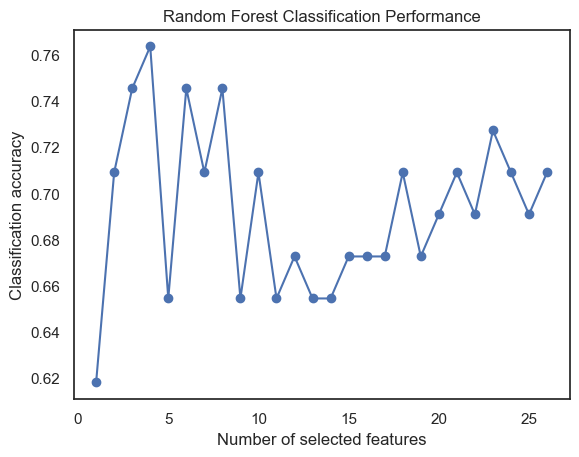

In [155]:
# Plot the results using a line graph

#num_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19,20, 21, 22, 23, 24]

plt.plot(range(1,27), accuracy, 'bo-')
plt.xlabel('Number of selected features')
plt.ylabel('Classification accuracy')
plt.title('Random Forest Classification Performance')
plt.show()


**Conclusion**: From the graph, we can see that model with 4 features has the highest accuracy. The accuracy of adding the fifth feature dropped a lot while the accuracy of adding more features oscillates up and down. 

## (f) Removing individual differences
Remove the most informative features of the Native/Non-Native English speakers from the original feature set. Using the revised
feature set, use the same machine learning algorithm as in (d) to estimate state anxiety. Please report the results similar to (d) and discuss your findings.

Remove mfcc_1 & RMSenergy & pause_frequency & mfcc_12 features from the original feature set

In [157]:
# Load the dataset
X = features.iloc[:, [0,1,2,3,4,5,6,7,10,11,12,13,14,15,16,17,18,19,21,22,23,25]] 
y = features[["Language"]]

In [164]:
# Create a random forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100, random_state=42)
    
# Use 5-fold cross-validation to evaluate the classification accuracy
kf = KFold(n_splits = 5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X, y, cv=kf)
    
# Calculate the average classification accuracy across the folds
acc_score = sum(scores) / len(scores)

C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\MEI-KUEI LU\anaconda3\envs\test\lib\site-packages\sklearn\model_selection

In [161]:
print(f"The Classification Accuracy is {acc_score}") 

The Classification Accuracy is 0.6909090909090909


**Conclusion**: Comparing to the best model in (d), the accuracy of (f) is not as high as the highest accuracy (0.76) but performs average in the different number of selected features graph and has similar result with Model 2. 

## (g) Feature transformation
Split the original data samples randomly into training (80%) and testing (20%). Use principal component analysis (PCA) to reduce the dimensionality of the original features. Estimate the PCA eigenvalues and eigenvectors based on the training data. Use the PCA components learned based on the training data to transform the testing data. Provide a plot of the eigenspectrum (i.e., sum of eigenvalues with increasing number of principal components) for the training data. Based on the eigenspectrum, choose an optimal number M* of principal components. Based on this optimal number M*, train any machine learning that you would like on state anxiety and report the absolute error between the actual and predicted state anxiety values on the testing data.

In [169]:
X = features.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,26]] 
y = features[["StateAnxiety"]]

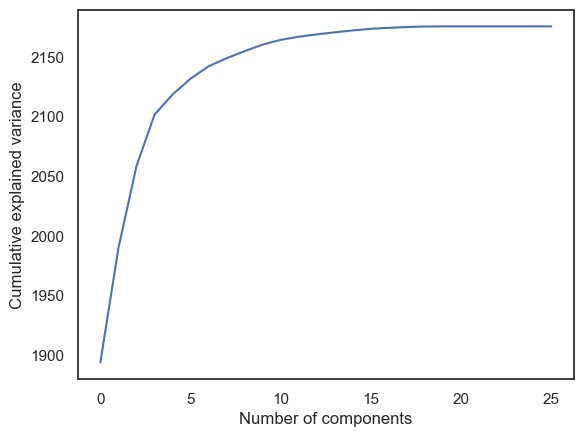

Optimal number of components: 4
Mean absolute error: 10.014781144781146


C:\Users\MEI-KUEI LU\AppData\Local\Temp\ipykernel_2104\3258384678.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_pca, y_train)


In [170]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit PCA to training data
pca = PCA()
pca.fit(X_train)

# Plot eigenspectrum
eigenvalues = pca.explained_variance_
plt.plot(np.cumsum(eigenvalues))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

# Choose optimal number of components based on eigenspectrum
M_star = np.where(np.cumsum(eigenvalues)/np.sum(eigenvalues) >= 0.95)[0][0] + 1
print(f'Optimal number of components: {M_star}')

# Transform training and testing data using PCA
X_train_pca = pca.transform(X_train)[:, :M_star]
X_test_pca = pca.transform(X_test)[:, :M_star]

# Train random forest model on training data
rf = RandomForestRegressor()
rf.fit(X_train_pca, y_train)

# Make predictions on testing data
y_pred = rf.predict(X_test_pca)

# Calculate mean absolute error on testing data
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean absolute error: {mae}')



In [181]:
# Print eigenvectors
eigenvectors = pca.components_
print(f'Eigenvectors:\n {eigenvectors}')

Eigenvectors:
 [[-8.08428243e-03 -1.94105519e-04  5.87422246e-03  3.39908491e-02
   3.21055129e-04  5.17013668e-03  2.01321327e-03 -3.92266269e-04
  -1.61035811e-05  4.82787395e-03 -4.19972480e-03 -2.30227658e-02
   8.04920479e-03 -5.35957262e-02  2.24116365e-02  4.07922566e-03
  -4.00910706e-02 -2.11247512e-02 -2.14421811e-02 -2.23121870e-02
  -6.75365026e-03 -2.85792887e-04  1.69381165e-03  9.95773306e-01
  -7.89069578e-03 -1.50665900e-04]
 [-8.15728190e-03 -1.23575957e-03 -2.39292079e-01 -9.43883742e-01
   4.14116404e-04 -2.11022798e-02 -1.28347521e-02  1.08582184e-03
   1.13796113e-04 -6.13268103e-04 -9.20379095e-02  4.67926194e-02
  -1.00244376e-01 -2.28385401e-02 -7.20828407e-03 -4.12178955e-02
   2.33085700e-02 -1.00566194e-01 -2.42504716e-02 -5.64843920e-03
  -1.25681370e-01  5.31938218e-04  6.21802992e-04  3.16212984e-02
   9.59250070e-04  9.31992419e-03]
 [ 1.08272839e-02  1.56759471e-03  2.78571717e-02 -5.17727605e-04
   7.69386442e-05 -1.84705188e-02 -7.48309374e-03  2.1379

In [183]:
# Print eigenvalues
eigenvalues = pca.explained_variance_
print(f'Eigenvalues:\n {eigenvalues}')

Eigenvalues:
 [1.89396505e+03 9.55893443e+01 6.86526053e+01 4.30961541e+01
 1.69474712e+01 1.32156127e+01 1.03971505e+01 6.80383679e+00
 5.88289287e+00 5.50181666e+00 3.96477368e+00 2.61937221e+00
 1.97008823e+00 1.73263362e+00 1.56988725e+00 1.37842599e+00
 7.72400528e-01 6.96138075e-01 4.20881340e-01 1.10318971e-01
 6.25372478e-03 2.70448778e-03 9.11052857e-04 6.99609165e-05
 2.86873647e-05 6.10282726e-06]
